<a href="https://colab.research.google.com/github/Kushagrasaxena11/Sentiment_analysis_on_1_6_million_tweets/blob/main/Sentiment_analysis_on_1_6_million_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

In [3]:
pip install opendatasets

In [4]:
import opendatasets as od

In [5]:
od.download("https://www.kaggle.com/kazanova/sentiment140")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kushagrasaxena95
Your Kaggle Key: ··········


100%|██████████| 80.9M/80.9M [00:02<00:00, 33.4MB/s]


In [6]:
df=pd.read_csv('/content/sentiment140/training.1600000.processed.noemoticon.csv',encoding="latin_1",  names=['target', 'ids', 'date', 'flag', 'user', 'text'])
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [8]:
df.shape

(1600000, 6)

In [9]:
# Dta Structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
# Summary Statistics
df.describe()

,target,ids
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [11]:
# Lets check the Duplicates present in the Data
df.duplicated().sum()

0

In [12]:
# Lets Explore the id column
df_ids=df['ids'].min()
print("The Minimum ids are:",df_ids)
df_ids1=df['ids'].max()
print("The Maximum ids are:",df_ids1)
df_ids2=df['ids'].sum()
print("The sum of ids are:",df_ids2)

The Minimum ids are: 1467810369
The Maximum ids are: 2329205794
The sum of ids are: 3198108083673004


In [13]:
# Lets explore the flag column
df_flag=df['flag'].describe()
df_flag

count      1600000
unique           1
top       NO_QUERY
freq       1600000
Name: flag, dtype: object

In [14]:
# Lets Explore the user column
df['user'].value_counts().head(10)

lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        276
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
Name: user, dtype: int64

In [15]:
df_1=df['target'].value_counts()
df_target=pd.DataFrame(df_1)
df_target=df_target.reset_index()
df_target.columns = ['target', 'count']
df_target['target'] = df_target['target'].apply(lambda x: 1 if x == 4 else x)

# Now df_target DataFrame will have 1 for positive tweets and 0 for negative tweets
df_target.head()

,target,count
0,0,800000
1,1,800000


In [16]:
# First, let's get the value counts of the 'target' column
df_1 = df['target'].value_counts()

# Create a DataFrame with the counts
df_target = pd.DataFrame(df_1)

# Reset the index to have the 'target' values as a column
df_target = df_target.reset_index()

# Rename the columns
df_target.columns = ['target', 'count']

# Filter the DataFrame to get counts of positive (1) and negative (0) tweets
positive_count = df_target[df_target['target'] == 1]['count'].values
negative_count = df_target[df_target['target'] == 0]['count'].values

# Determine which value represents positive tweets based on counts
if len(positive_count) > 0 and (len(negative_count) == 0 or positive_count[0] > negative_count[0]):
    positive_value = 0
    negative_value = 1
elif len(negative_count) > 0:
    positive_value = 1
    negative_value = 0
else:
    # Handle the case where both counts are empty
    positive_value = None
    negative_value = None

if positive_value is not None and negative_value is not None:
    print(f"Assuming {df_target['count'].sum()} tweets:")
    print(f"Value {positive_value} represents positive tweets.")
    print(f"Value {negative_value} represents negative tweets.")
else:
    print("Unable to determine which value represents positive or negative tweets.")

Assuming 1600000 tweets:
Value 1 represents positive tweets.
Value 0 represents negative tweets.


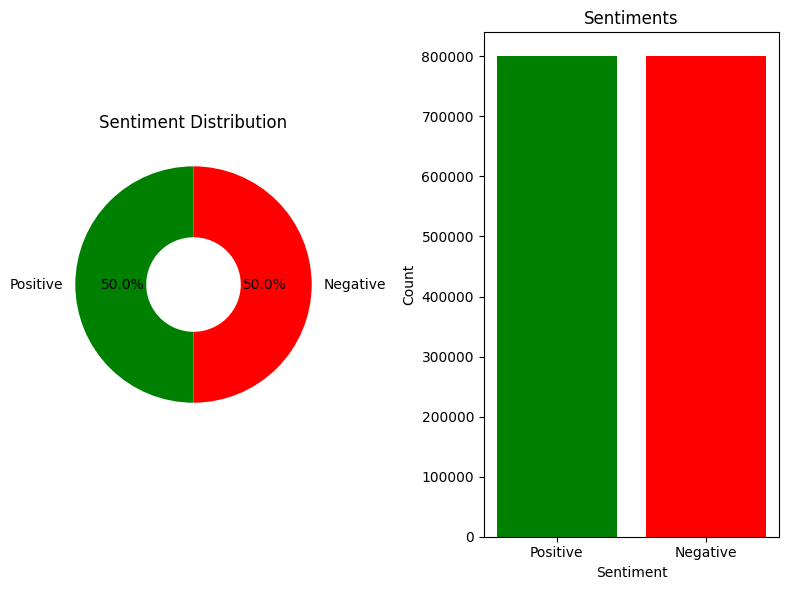

In [17]:
import matplotlib.pyplot as plt
df_target = (
    df['target'].value_counts().to_frame(name='count').reset_index()
    .rename(columns={'index': 'target'})
)

# Convert 'target' to numeric (1 for positive, 0 for negative)
df_target['target'] = df_target['target'].replace(4, 1)

# Calculate user counts for positive and negative tweets
positive_tweets = df_target[df_target['target'] == 1]['count'].sum()
negative_tweets = df_target[df_target['target'] == 0]['count'].sum()

#sunplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))

# Pie Chart for Sentiment Distribution
ax1.pie(
    [positive_tweets, negative_tweets],
    labels=['Positive', 'Negative'],
    autopct="%1.1f%%",
    startangle=90,
    colors=['green', 'red'],
    wedgeprops=dict(width=0.6)
)
ax1.set_title('Sentiment Distribution')

# Bar Chart for User Counts
ax2.bar(['Positive', 'Negative'], [positive_tweets, negative_tweets], color=['green', 'red'])
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Count')
ax2.set_title('Sentiments')

# Tight layout for better overall plot arrangement
plt.tight_layout()

# Display the combined plot
plt.show()

In [18]:
import re

# Function to remove HTML tags
def remove_html_tags(text):
    clean_text = re.sub(r'<.*?>', '', text)
    return clean_text

# Function to remove URLs
def remove_urls(text):
    clean_text = re.sub(r'http\S+', '', text)
    return clean_text

In [19]:
import string

# Function to convert text to lowercase
def convert_to_lowercase(text):
    return text.lower()

# Function to replace chat words
def replace_chat_words(text):
    chat_words = {
        "BRB": "Be right back",
        "BTW": "By the way",
        "OMG": "Oh my God/goodness",
        "TTYL": "Talk to you later",
        "OMW": "On my way",
        "SMH/SMDH": "Shaking my head/shaking my darn head",
        "LOL": "Laugh out loud",
        "TBD": "To be determined",
        "IMHO/IMO": "In my humble opinion",
        "HMU": "Hit me up",
        "IIRC": "If I remember correctly",
        "LMK": "Let me know",
        "OG": "Original gangsters (used for old friends)",
        "FTW": "For the win",
        "NVM": "Nevermind",
        "OOTD": "Outfit of the day",
        "Ngl": "Not gonna lie",
        "Rq": "real quick",
        "Iykyk": "If you know, you know",
        "Ong": "On god (I swear)",
        "YAAAS": "Yes!",
        "Brt": "Be right there",
        "Sm": "So much",
        "Ig": "I guess",
        "Wya": "Where you at",
        "Istg": "I swear to god",
        "Hbu": "How about you",
        "Atm": "At the moment",
        "Asap": "As soon as possible",
        "Fyi": "For your information"
    }
    for word, expanded_form in chat_words.items():
        text = text.replace(word, expanded_form)
    return text

In [20]:
import string,time
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
from nltk.corpus import stopwords

# Function to remove punctuation
def remove_punctuation(text):
    clean_text = ''.join(ch for ch in text if ch not in string.punctuation)
    return clean_text

# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [22]:
# Function to remove whitespace
def remove_whitespace(text):
    return text.strip()

# Function to remove special characters
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return clean_text

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
# Combine all data cleaning functions into one preprocessing function
def preprocess_text(text):
    text = remove_html_tags(text)
    text = remove_urls(text)
    text = convert_to_lowercase(text)
    text = replace_chat_words(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_whitespace(text)
    text = remove_special_characters(text)
    return text

# Apply preprocessing function to DataFrame
df['text'] = df['text'].apply(preprocess_text)

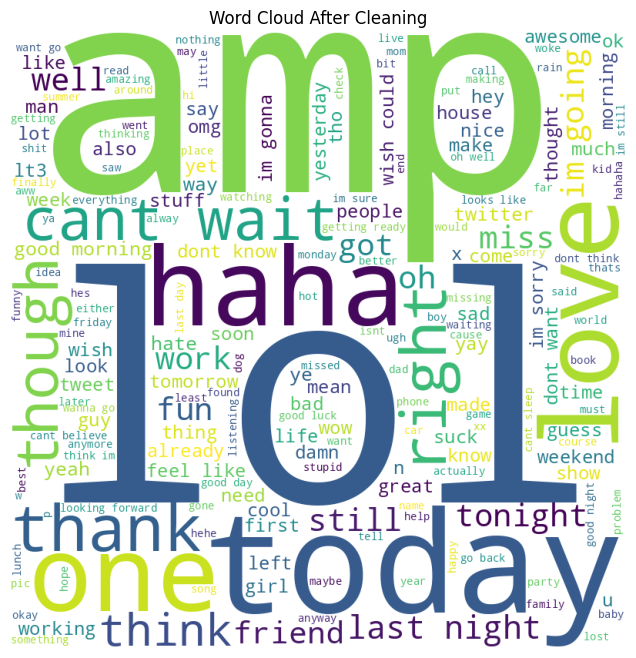

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from nltk.corpus import stopwords

# Define stopwords
stop_words = set(stopwords.words('english'))

# Function to generate word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=stop_words,
                          min_font_size=10).generate(text)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Apply preprocessing function to DataFrame
df['text'] = df['text'].apply(preprocess_text)

# Generate word cloud from cleaned text
generate_word_cloud(' '.join(df['text']), 'Word Cloud After Cleaning')

<ipython-input-26-996d742e1109>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette='viridis')


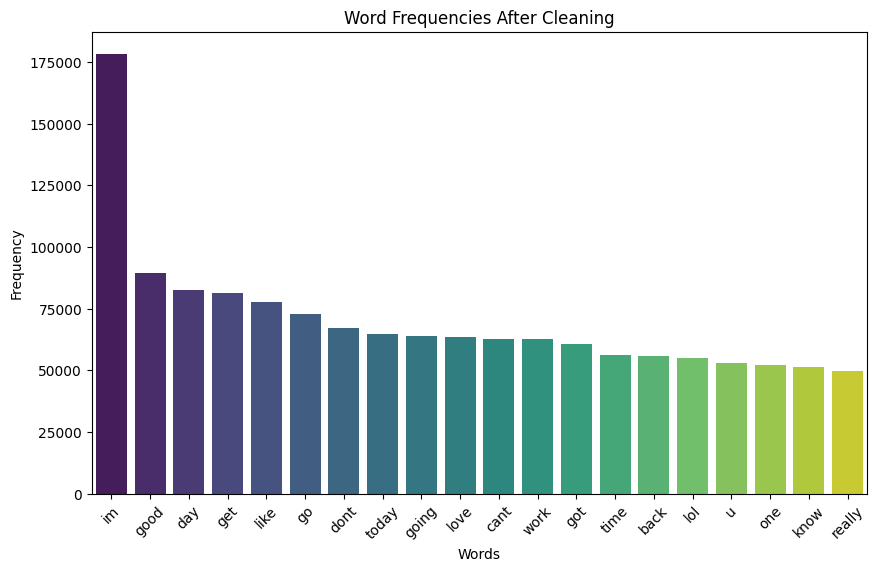

In [26]:
# Function to plot bar plot of word frequencies
def plot_word_frequencies(text, title):
    word_freq = nltk.FreqDist(text.split())
    common_words = word_freq.most_common(20)
    words, freqs = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(freqs), palette='viridis')
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()
# Step 3: Plot bar plots of word frequencies
plot_word_frequencies(' '.join(df['text']), 'Word Frequencies After Cleaning')
# plot_word_frequencies(' '.join(df['user']), 'User Word Frequencies After Cleaning')
# plot_word_frequencies(' '.join(df['flag']), 'Flag Word Frequencies After Cleaning')

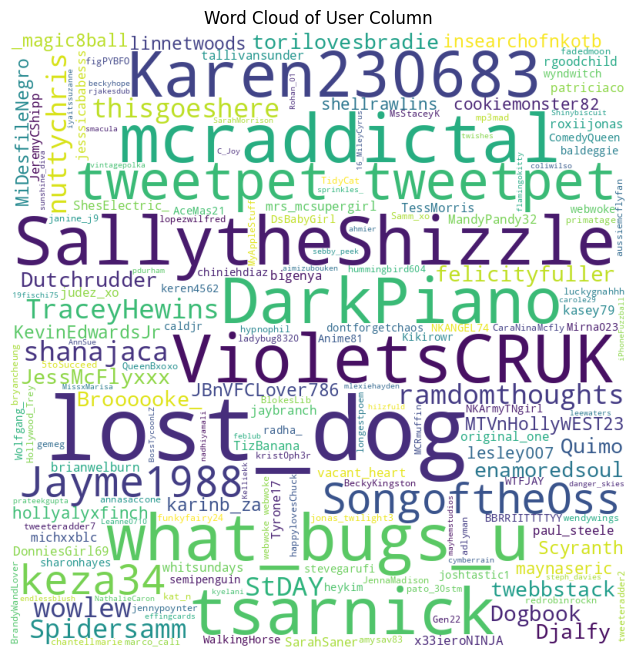

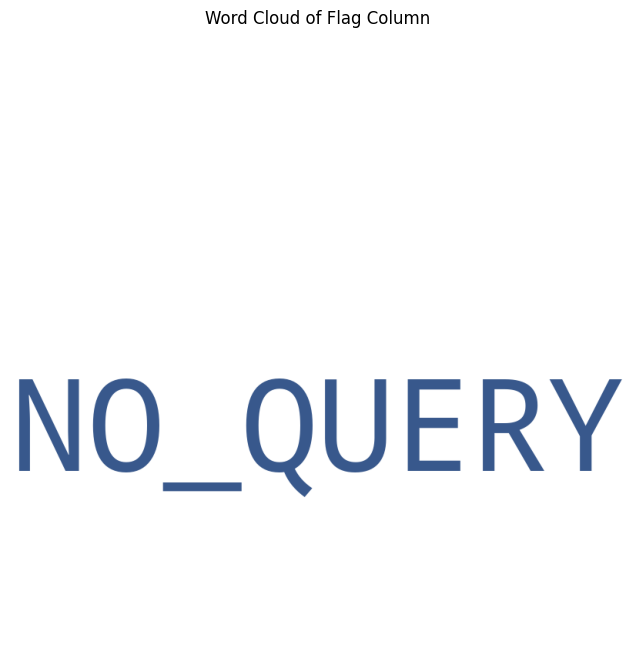

In [27]:
generate_word_cloud(' '.join(df['user']), 'Word Cloud of User Column')
generate_word_cloud(' '.join(df['flag']), 'Word Cloud of Flag Column')

<ipython-input-26-996d742e1109>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette='viridis')


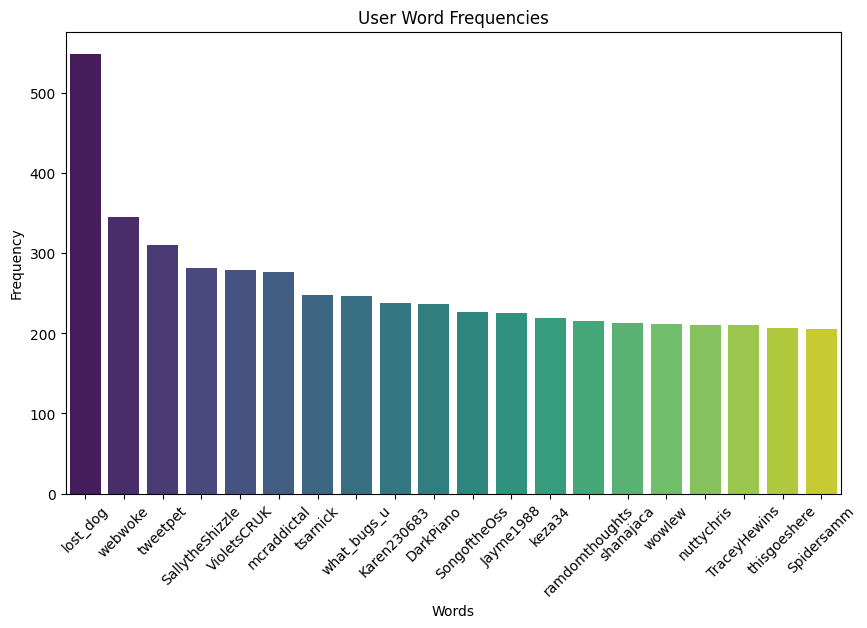

<ipython-input-26-996d742e1109>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(freqs), palette='viridis')


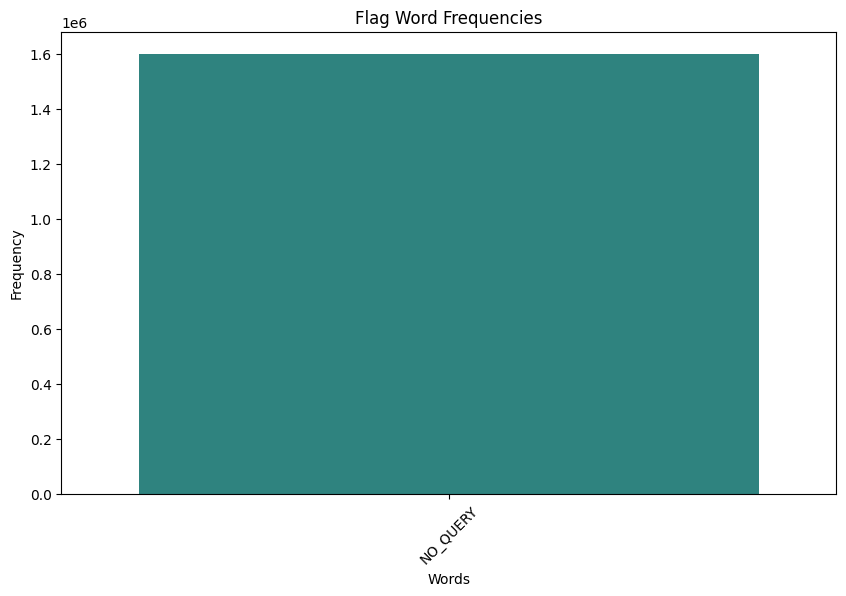

In [28]:
plot_word_frequencies(' '.join(df['user']), 'User Word Frequencies')
plot_word_frequencies(' '.join(df['flag']), 'Flag Word Frequencies')

In [29]:
# Lets Check Unique values after Data Cleaning
df['text'].unique()

array(['switchfoot awww thats bummer shoulda got david carr third day',
       'upset cant update facebook texting might cry result school today also blah',
       'kenichan dived many times ball managed save 50 rest go bounds',
       ..., 'ready mojo makeover ask details',
       'happy 38th birthday boo alll time tupac amaru shakur',
       'happy charitytuesday thenspcc sparkscharity speakinguph4h'],
      dtype=object)

In [30]:
df.isnull().sum().sort_values(ascending=False)

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Convert tokenized text to BoW features
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])

# Assuming df is your DataFrame with the target column modified
y = df['target']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predict on the testing set
y_pred = logreg.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

Logistic Regression Accuracy: 0.782146875


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
X_sequences = tokenizer.texts_to_sequences(df['text'])
max_len = 100  # Example sequence length
X_pad = pad_sequences(X_sequences, maxlen=max_len)

# Define target variable
y = df['target'].replace(4, 1).values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

# Model definition
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
# Model definition with increased complexity and regularization
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(Bidirectional(LSTM(units=256, dropout=0.5, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(units=128, dropout=0.5, recurrent_dropout=0.2)))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile model with L2 regularization
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print("BiLSTM Accuracy:", accuracy)

print(model.summary())